In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# X-Data
N = 200
X = np.random.random(N)

sign = (-np.ones((N, )))**np.random.randint(2,size=N)
Y = np.sqrt(X) * sign

/home/zinzinbin/.conda/envs/research-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
class SimpleDNN(torch.nn.Module):
    def __init__(self, input_dims, output_dims, hiddens):
        super(SimpleDNN, self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.hiddens = hiddens

        self.input_layer = torch.nn.Linear(input_dims, hiddens)
        self.bn1 = torch.nn.BatchNorm1d(hiddens)
        self.middle_layer = torch.nn.Linear(hiddens, hiddens)
        self.bn2 = torch.nn.BatchNorm1d(hiddens)
        self.output_layer = torch.nn.Linear(hiddens, output_dims)

    def forward(self, inputs : torch.Tensor)->None:
        x = torch.nn.functional.relu(self.bn1(self.input_layer(inputs)))
        x = torch.nn.functional.relu(self.bn2(self.middle_layer(x)))
        x = self.output_layer(x)

        return x

In [33]:
from tqdm import tqdm

def train_per_epoch(
    model : torch.nn.Module, 
    dataloader : torch.utils.data.DataLoader, 
    optimizer : torch.optim.Optimizer,
    loss_fn : torch.nn.Module, 
    device : str = "cpu"):

    train_loss = 0

    for idx, batch in enumerate(dataloader):

        optimizer.zero_grad()

        batch_x, batch_y = batch
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        batch_output = model(batch_x)
        batch_loss = loss_fn(batch_output, batch_y)

        batch_loss.backward()
        optimizer.step()
        
        train_loss += batch_loss.detach().cpu().numpy()

    train_loss /= idx + 1

    return train_loss
    

def train(
    model : torch.nn.Module, 
    dataloader : torch.utils.data.DataLoader, 
    optimizer : torch.optim.Optimizer,
    loss_fn : torch.nn.Module, 
    num_epochs : int = 42,
    device : str = "cpu"
    ):

    train_loss_list = []

    for epoch in tqdm(range(num_epochs)):
        train_loss = train_per_epoch(
            model,
            dataloader,
            optimizer,
            loss_fn,
            device
        )

        train_loss_list.append(train_loss)

    return train_loss_list

In [34]:
class SampleDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        super(SampleDataset, self).__init__()
        self.X = X
        self.Y = Y
    
    def __getitem__(self, idx):
        batch_x = X[idx]
        batch_y = Y[idx]

        batch_x = torch.tensor([batch_x], dtype = torch.float32)
        batch_y = torch.tensor([batch_y], dtype = torch.float32)

        return batch_x, batch_y

    def __len__(self):
        return len(self.X)

dataset = SampleDataset(X,Y)
dataloader = torch.utils.data.DataLoader(dataset, num_workers=4, batch_size=16, shuffle = True)

In [35]:
sample_x, sample_y = next(iter(dataloader))

print("sample_x : ", sample_x.size())
print("sample_y : ", sample_y.size())

sample_x :  torch.Size([16, 1])
sample_y :  torch.Size([16, 1])


In [38]:
model = SimpleDNN(1, 1, 16)
loss_fn = torch.nn.MSELoss(reduction = "mean")
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)

print("torch.cuda available : ", torch.cuda.is_available())
print("# of device : ", torch.cuda.device_count())

device = "cuda:0"

model.to(device)

train_loss_list = train(
    model = model,
    dataloader = dataloader,
    optimizer = optimizer,
    loss_fn=loss_fn,
    num_epochs=64,
    device = device
)

torch.cuda available :  True
# of device :  2


100%|██████████| 64/64 [00:12<00:00,  5.07it/s]


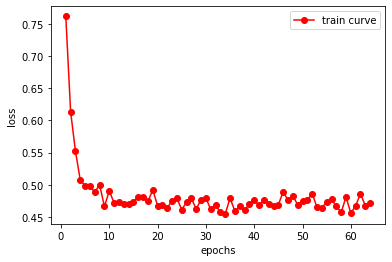

In [39]:
# train curve
epochs = range(1, len(train_loss_list) + 1)
plt.plot(epochs, train_loss_list, 'ro-', label = "train curve")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

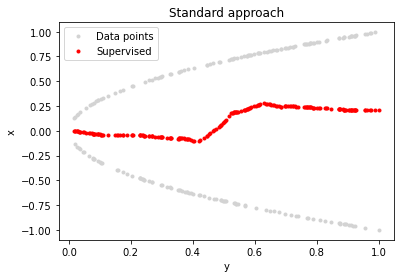

In [51]:
model.eval()

Xs = []
reals = []
predictions = []

with torch.no_grad():
    for idx, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_x, batch_y = batch
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        batch_output = model(batch_x)

        Xs.extend(batch_x.cpu().numpy().reshape(-1,).tolist())
        reals.extend(batch_y.cpu().numpy().reshape(-1,).tolist())
        predictions.extend(batch_output.cpu().numpy().reshape(-1,).tolist())
        
# Results
plt.plot(Xs, reals,'.',label='Data points', color="lightgray") 
plt.plot(Xs, predictions, '.',label='Supervised', color="red") 
plt.xlabel('y')
plt.ylabel('x')
plt.title('Standard approach') 
plt.legend()
plt.show()

torch.cuda available :  True
# of device :  2


100%|██████████| 64/64 [00:12<00:00,  5.09it/s]


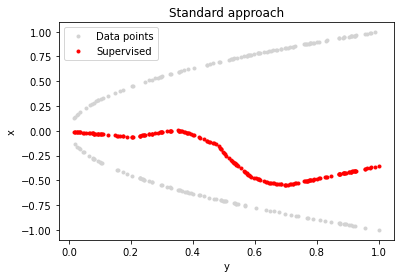

In [52]:
# loss_fn change

def loss_fn_edit(y_pred, y_true):
    return loss_fn(y_pred ** 2, y_true)

model = SimpleDNN(1, 1, 16)
loss_fn = torch.nn.MSELoss(reduction = "mean")
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)

print("torch.cuda available : ", torch.cuda.is_available())
print("# of device : ", torch.cuda.device_count())

device = "cuda:0"

model.to(device)

train_loss_list = train(
    model = model,
    dataloader = dataloader,
    optimizer = optimizer,
    loss_fn=loss_fn_edit,
    num_epochs=64,
    device = device
)

model.eval()

Xs = []
reals = []
predictions = []

with torch.no_grad():
    for idx, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_x, batch_y = batch
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        batch_output = model(batch_x)

        Xs.extend(batch_x.cpu().numpy().reshape(-1,).tolist())
        reals.extend(batch_y.cpu().numpy().reshape(-1,).tolist())
        predictions.extend(batch_output.cpu().numpy().reshape(-1,).tolist())
        
# Results
plt.plot(Xs, reals,'.',label='Data points', color="lightgray") 
plt.plot(Xs, predictions, '.',label='Supervised', color="red") 
plt.xlabel('y')
plt.ylabel('x')
plt.title('Standard approach') 
plt.legend()
plt.show()